In [0]:
import pandas as pd
from scipy.integrate import odeint
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

In [0]:
import random

In [0]:
from statistics import mean 

In [0]:
import itertools

In [0]:
import ga

In [0]:
dataset=pd.read_csv("C:\\Users\\franc\\Desktop\\UNIVERSITA\\bioinformatica\\progetto\\dpc-covid19-ita-andamento-nazionale-24aprile.csv",parse_dates=['data'])

In [0]:
data=dataset[['totale_positivi','dimessi_guariti','deceduti']]

In [0]:
def deriv(y,t):  
    '''set di equazioni differenziali'''
    Sani,Infetti,Morti,Guariti = y 
    dSani_dt=-k1*Sani*Infetti-k1*Sani*Infetti
    dInfetti_dt=+k1*Sani-k2*Infetti-k3*Infetti
    dMorti_dt=k2*Infetti
    dGuariti_dt=k3*Infetti
    return dSani_dt,dInfetti_dt,dGuariti_dt ,dMorti_dt  # For odeint

In [0]:
def diffusione(orizzonte_temporale_in_gg=10,Sani = 3208,
    
    Infetti=100,
    Guariti=0,

    Morti= 2,
  ):
    y0 =  [Sani,Infetti,Morti,Guariti]
    t = np.linspace(0,orizzonte_temporale_in_gg,orizzonte_temporale_in_gg)
   
    ret = odeint(deriv, y0, t)
    return(ret)

In [0]:
def fitness(previsti):
    df=pd.DataFrame(previsti,columns=['sani','totale_positivi','dimessi_guariti','deceduti'])
    df=df.drop(columns=['sani'])
    dataframe=((df-data)**2)
    lista=dataframe.values.tolist()
    merged = list(itertools.chain.from_iterable(lista))
    media=mean(merged)
    return(media)

In [0]:
def perturbazione(ls):
    sup = 0.2
    for i in range(len(ls)):
        if ls[i] < 0.5:
            ls[i]=random.uniform(ls[i],ls[i]+sup)
        else:
            ls[i]=random.uniform(0,ls[i]-sup)
    return(ls)
    

In [0]:
iniziale = [random.uniform(0,1),random.uniform(0,1),random.uniform(0,1)]

In [0]:
k1=iniziale[0]
k2=iniziale[1]
k3=iniziale[2]

In [0]:
k1

0.713151883599744

## ILS

In [0]:
def localsearch(massimovaloreiniziale,iterazioni):
    iniziale = [random.uniform(0,massimovaloreiniziale),random.uniform(0,massimovaloreiniziale),random.uniform(0,massimovaloreiniziale)]
    k=[iniziale[0],iniziale[1],iniziale[2]]
    k1=iniziale[0]
    k2=k[1]
    k3=k[2]
    errore=100000000000000000000000000000000000000
    val='1'
    for c in range(iterazioni):
        valori=diffusione(61,Sani = 6036000,Infetti=221,Guariti=1,Morti= 7)
        stimaerrore=fitness(valori)
        if stimaerrore<errore:
            errore=stimaerrore
            val=valori
            k[0]=iniziale[0]
            k[1]=iniziale[1]
            k[2]=iniziale[2]
        iniziale=[random.uniform(0,massimovaloreiniziale),random.uniform(0,massimovaloreiniziale),random.uniform(0,massimovaloreiniziale)]
        
        k1=iniziale[0]
        k2=iniziale[1]
        k3=iniziale[2]
    return(k,val,errore)

In [0]:
localsearch(1,4)

([0.9363725660981266, 0.47475242756040725, 0.27914704025914905],
 array([[ 6.03600000e+06,  2.21000000e+02,  7.00000000e+00,
          1.00000000e+00],
        [-5.70555785e-09,  8.05049520e+02,  1.24710878e+03,
          4.23694420e+02],
        [-4.97988163e-08,  2.62519041e+02,  1.65172480e+03,
          5.61608880e+02],
        [ 5.12388660e-12,  8.56049790e+01,  1.78366626e+03,
          6.06581482e+02],
        [ 9.96582889e-09,  2.79149758e+01,  1.82669112e+03,
          6.21246622e+02],
        [ 4.65541396e-08,  9.10281014e+00,  1.84072112e+03,
          6.26028786e+02],
        [ 4.44784376e-11,  2.96834016e+00,  1.84529618e+03,
          6.27588205e+02],
        [ 9.21153205e-12,  9.67947583e-01,  1.84678806e+03,
          6.28096717e+02],
        [ 1.09424321e-11,  3.15638553e-01,  1.84727454e+03,
          6.28262537e+02],
        [ 2.29576740e-11,  1.02926749e-01,  1.84743318e+03,
          6.28316610e+02],
        [ 5.79991172e-11,  3.35634428e-02,  1.84748491e+03,
     

In [0]:
def ils(iterazioni,max_iterazioni,massimovaloreiniziale):
    iniziale = [random.uniform(0,massimovaloreiniziale),random.uniform(0,massimovaloreiniziale),random.uniform(0,massimovaloreiniziale)]
    loc_search = localsearch(massimovaloreiniziale,iterazioni)
    k=loc_search[0]
    best_val = loc_search[1]
    best_errore = loc_search[2]
    #iter_errore = [best_errore]
    #iter_best_errore = [best_errore]
    for c in range(max_iterazioni):
        val=best_val
        nuova_iniziale = perturbazione(k)
        loc_search = localsearch(massimovaloreiniziale,iterazioni)
        val = loc_search[1]
        if loc_search[2] < best_errore: # Se nuovo errore minore best si aggiorna il best
            best_errore = loc_search[2]
            best_val= loc_search[1]
            k=loc_search[0]
       # elif loc_search[0] == best_pers and loc_search[1] < best_num: # se uguale si tiene come best il numero più piccolo
               # best_num =loc_search[1]
        #iter_pers.append(loc_search[0])
       # iter_best_pers.append(best_pers)
   # results = {"errore":iter_pers, "persistenza_migliore":iter_best_pers, "numero_migliore":best_num,"ripetizioni":conta(best_num)}
    return(k,best_val,best_errore)    

In [0]:
prova=ils(10,10,1)

In [0]:
 def grafico(alpha,ret):
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111)
    t = np.linspace(0,61,61)
    ax.plot(t, ret[:,1], 'r', alpha=0.7 ,lw=2, label='Infetti')
    ax.plot(t, ret[:,2], 'g', alpha=0.7 ,lw=2, label='Deceduti')
    ax.plot(t, ret[:,3], 'k', alpha=0.7, lw=2, label='Guariti')
    ax.set_xlabel('tempo (in giorni)')
    ax.set_ylabel('Persone (x1000)')
    ax.set_ylim(0,100000*2)
    legend = ax.legend()
    plt.text(1,2800,'alpha='+str(alpha))
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

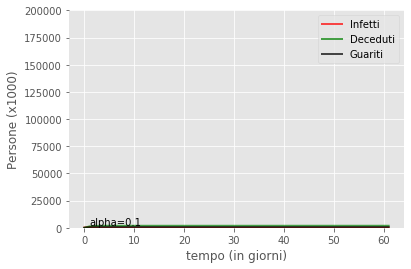

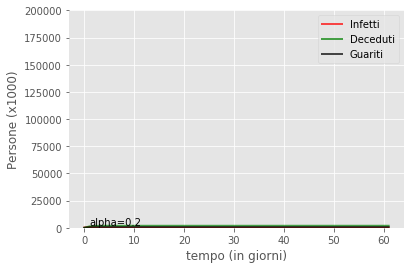

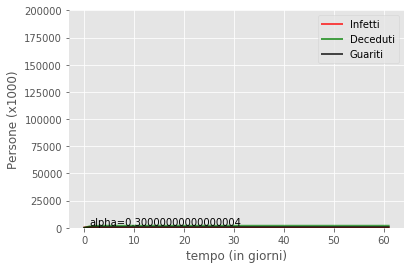

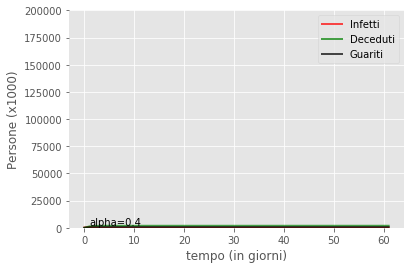

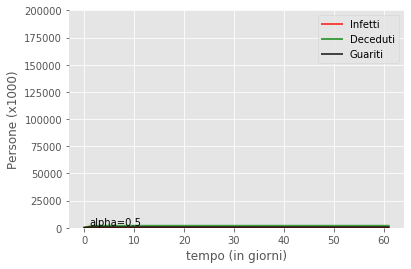

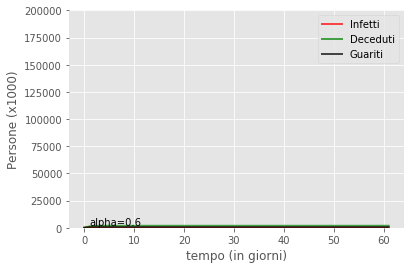

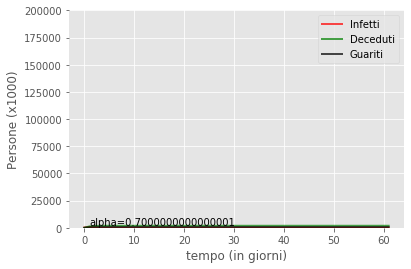

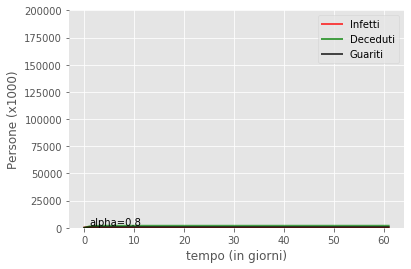

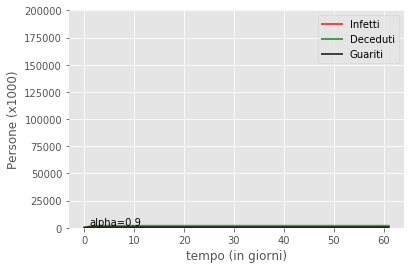

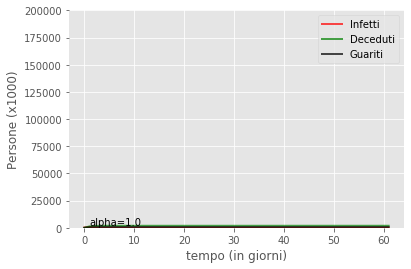

In [0]:
for alpha in np.linspace(0.1,1,10):
    grafico(alpha,prova[1])

In [0]:
prova

([0.1426206650003333, 0.5046856572268021, 0.5345521767828044],
 array([[ 6.03600000e+06,  2.21000000e+02,  7.00000000e+00,
          1.00000000e+00],
        [-5.70555785e-09,  8.05049520e+02,  1.24710878e+03,
          4.23694420e+02],
        [-4.97988163e-08,  2.62519041e+02,  1.65172480e+03,
          5.61608880e+02],
        [ 5.12388660e-12,  8.56049790e+01,  1.78366626e+03,
          6.06581482e+02],
        [ 9.96582889e-09,  2.79149758e+01,  1.82669112e+03,
          6.21246622e+02],
        [ 4.65541396e-08,  9.10281014e+00,  1.84072112e+03,
          6.26028786e+02],
        [ 4.44784376e-11,  2.96834016e+00,  1.84529618e+03,
          6.27588205e+02],
        [ 9.21153205e-12,  9.67947583e-01,  1.84678806e+03,
          6.28096717e+02],
        [ 1.09424321e-11,  3.15638553e-01,  1.84727454e+03,
          6.28262537e+02],
        [ 2.29576740e-11,  1.02926749e-01,  1.84743318e+03,
          6.28316610e+02],
        [ 5.79991172e-11,  3.35634428e-02,  1.84748491e+03,
       